# Neural Networks
Content:
- **Linear Regression**
    - using sklearn
    - normal equation
    - as numerical optimization problem
    - as neural network
-  **Intuition behind Neural Networks**
-  **The universal approximation Theorem**

In [31]:
!pip install torch
!pip install numpy
!pip install pandas

In [1]:
COLOR = 'yellow'

def set_spines(ax): 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['bottom'].set_color(COLOR)
    ax.spines['left'].set_color(COLOR)

    # Make ticks and tick labels red for both x and y axes
    ax.tick_params(axis='x', colors=COLOR)  # X-axis ticks and labels
    ax.tick_params(axis='y', colors=COLOR)  # Y-axis ticks and labels
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labelleft=False)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets

### Linear Regression
- Todo unify shapes of coefficients to make smooth experience

In [3]:
def load_diabetes():
    x_columns = {'bp': 'bloodPressure', 
                 'bmi': 'bodyMassIndex',
                 's1': 'totalSerumCholesterol', 
                 's2': 'lowDensityLipoproteins',
                 's3': 'highDensityLipoproteins',
                 's4': 'totalCholesterol',
                 's5': 'serumTriglyceridesLevel',
                 's6': 'bloodSugarLevel'}
    x, y = datasets.load_diabetes(return_X_y=True, as_frame=True)
    x = x.rename(columns=x_columns)
    y = pd.DataFrame({'diseaseProgression': y})
    return x, y


def split_test_train(x, y):
    return 1/0


# Linear Regression
### Linear Regression using Sklearn

Text(0, 0.5, 'Disease Progression')

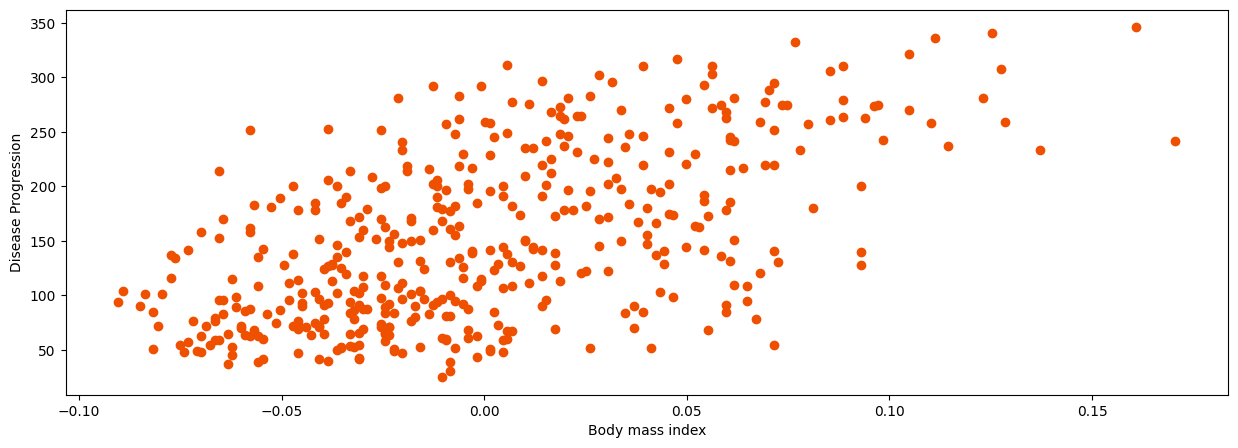

In [4]:
x, y = load_diabetes()

# Todo test train split
x_train, y_train = x, y
x_test, y_test = x, y

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')

In [5]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train[['bodyMassIndex']], y_train)
print(f"Intercept {regr.intercept_[0]}, Coefficient {regr.coef_[0,0]} ")
x_pred = x_test[['bodyMassIndex']].sort_values(by='bodyMassIndex')
y_pred = regr.predict(x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840388 


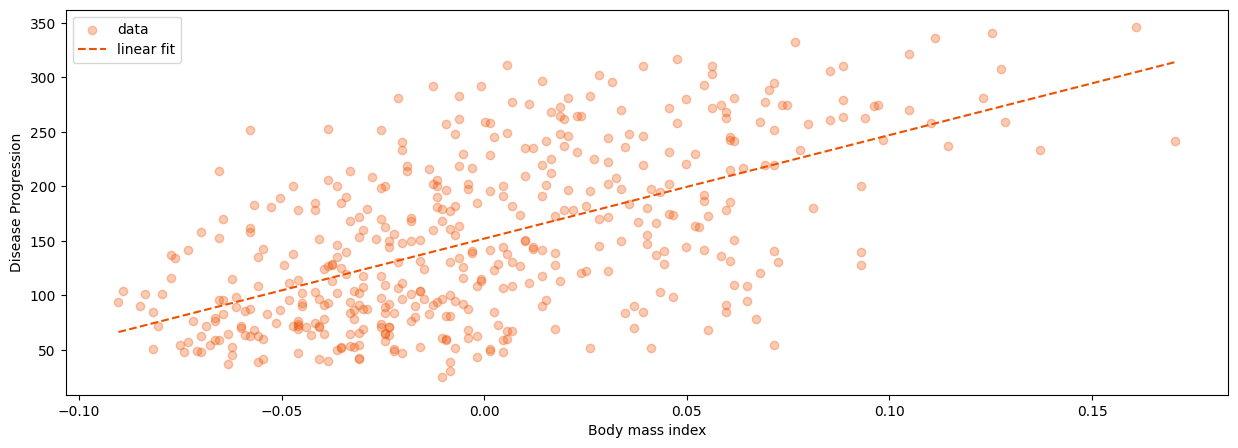

In [6]:

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred, y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()

### Linear Regression using the normal equation
The normal equation is a closed form solution of the linear regression problem. It gives the fit coefficients $\alpha$ in terms of matrix mulitplication.
Once the coefficients are calculated a prediction $\hat y$ can be made.
$$\alpha = (x^Tx)^{-1} x^T y$$
$$\hat y = \alpha^T x$$

In [7]:
def add_intercept(x):
    return x.assign(intercept = 1)
    
def fit_normal_equation(x, y):
    x_t = x.transpose()
    inverse = np.linalg.inv(x_t @ x)
    alpha = inverse @ x_t @ y
    return alpha

def predict_normal_equation(alpha, x):
    print (alpha.shape, x.shape)
    return x @ alpha
    

In [8]:
x_fit = add_intercept(x_train)[['intercept', 'bodyMassIndex']].values
y_fit = y_train.values
alpha = fit_normal_equation(x_fit, y_fit)
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")
x_pred = add_intercept(x_test)[['intercept', 'bodyMassIndex']].sort_values(by='bodyMassIndex').values
y_pred = predict_normal_equation(alpha, x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840387 
(2, 1) (442, 2)


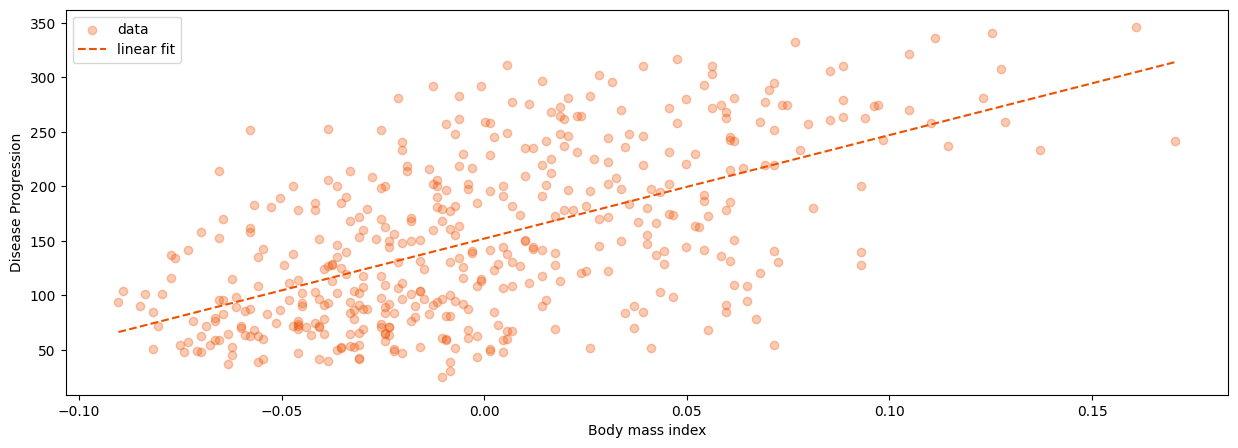

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred[:, 1], y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()


### Linear Regression as numerical optimization problem
- todo: rather use a method that uses gradients (`nelder-mead` does not)

In [10]:

from scipy import optimize

def reshape_alpha(alpha):
    return alpha[..., np.newaxis] 


def f(alpha):
    a = reshape_alpha(alpha)
    loss =  (x_fit @ a - y_fit)**2
    return loss.sum()

 
opt = optimize.minimize(f, np.array([0, 0]), method='nelder-mead')
alpha = reshape_alpha(opt['x'])
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")

Intercept 152.13348218121047, Coefficient 949.4352653323601 


### Linear Regression as Neural Network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) 

    def forward(self, x):
        return self.linear(x)

In [12]:
model = LinearRegressionModel()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=0.5)  # Stochastic Gradient Descent

x_fit_torch = torch.from_numpy(x_train[['bodyMassIndex']].values).to(torch.float32)
y_fit_torch = torch.from_numpy(y_train[['diseaseProgression']].values).to(torch.float32)


# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass: compute prediction and loss
    y_pred = model(x_fit_torch)
    loss = criterion(y_pred, y_fit_torch)
    
    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f},  intercept: {model.linear.bias.data[0]}, Coefficient {model.linear.weight.data[0, 0]}')

Epoch 100/5000, Loss: 5190.8999,  intercept: 152.13348388671875, Coefficient 192.99769592285156
Epoch 200/5000, Loss: 4717.1704,  intercept: 152.13348388671875, Coefficient 346.31341552734375
Epoch 300/5000, Loss: 4416.0127,  intercept: 152.13348388671875, Coefficient 468.55487060546875
Epoch 400/5000, Loss: 4224.5615,  intercept: 152.13348388671875, Coefficient 566.0203247070312
Epoch 500/5000, Loss: 4102.8530,  intercept: 152.13348388671875, Coefficient 643.7313842773438
Epoch 600/5000, Loss: 4025.4810,  intercept: 152.13348388671875, Coefficient 705.6915283203125
Epoch 700/5000, Loss: 3976.2939,  intercept: 152.13348388671875, Coefficient 755.093994140625
Epoch 800/5000, Loss: 3945.0244,  intercept: 152.13348388671875, Coefficient 794.4835205078125
Epoch 900/5000, Loss: 3925.1465,  intercept: 152.13348388671875, Coefficient 825.8892211914062
Epoch 1000/5000, Loss: 3912.5095,  intercept: 152.13348388671875, Coefficient 850.9299926757812
Epoch 1100/5000, Loss: 3904.4756,  intercept: 1

# Intuition behind neural networks
- The learning goal is to understand a neural network 
    - as piecewise linear approximation (for relu activation). 
    - hidden layers correspond to 'parallel' linear regressions. 
Todo: scale / speed up convergence for other functions

In [45]:
x = torch.arange(1, 10, 0.001).reshape(-1, 1)
y =  50* x + ( 10 * x + x**2) * torch.sin(3*x) 

# Create data
x_train = np.linspace(-   0 * np.pi, 1 * np.pi, 1000).reshape(-1, 1)
y_train = np.sin(x_train) 

# Convert data to torch tensors
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

In [161]:
class Foobar(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 4) 
        self.out = nn.Linear(4, 1)
        

    def forward(self, x):
        y = torch.relu(self.hidden(x))
        y = self.out(y)
        return y


model = Foobar()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Stochastic Gradient Descent


# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass: compute prediction and loss
    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Print loss every 100 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')

Epoch 1000/50000, Loss: 0.00070217
Epoch 2000/50000, Loss: 0.00068796
Epoch 3000/50000, Loss: 0.00068646
Epoch 4000/50000, Loss: 0.00068644
Epoch 5000/50000, Loss: 0.00068723
Epoch 6000/50000, Loss: 0.00068644
Epoch 7000/50000, Loss: 0.00068653
Epoch 8000/50000, Loss: 0.00096838
Epoch 9000/50000, Loss: 0.00068651
Epoch 10000/50000, Loss: 0.00068651
Epoch 11000/50000, Loss: 0.00068657
Epoch 12000/50000, Loss: 0.00068657
Epoch 13000/50000, Loss: 0.00068657
Epoch 14000/50000, Loss: 0.00068644
Epoch 15000/50000, Loss: 0.00068644
Epoch 16000/50000, Loss: 0.00068766
Epoch 17000/50000, Loss: 0.00068652
Epoch 18000/50000, Loss: 0.00068686
Epoch 19000/50000, Loss: 0.00068656
Epoch 20000/50000, Loss: 0.00068646
Epoch 21000/50000, Loss: 0.00068716
Epoch 22000/50000, Loss: 0.00068657
Epoch 23000/50000, Loss: 0.00068657
Epoch 24000/50000, Loss: 0.00068708
Epoch 25000/50000, Loss: 0.00068670
Epoch 26000/50000, Loss: 0.00068644
Epoch 27000/50000, Loss: 0.00068644
Epoch 28000/50000, Loss: 0.00068644
E

In [193]:
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred = model(x)
    hidden_components = model.hidden(x)
    bias = model.out.bias 
    weights = model.out.weight

n_hidden = hidden_components.shape[1]
n_plots = n_hidden + 2

In [206]:
regr = LinearRegression()
regr.fit(x, y)
y_pred_linear_regression_intuition = regr.predict(x)

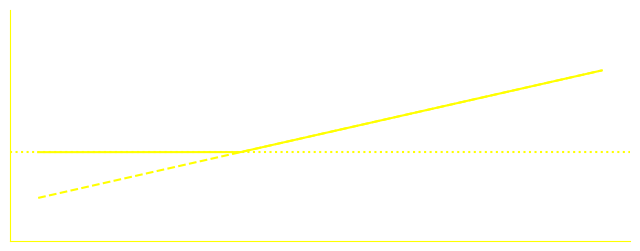

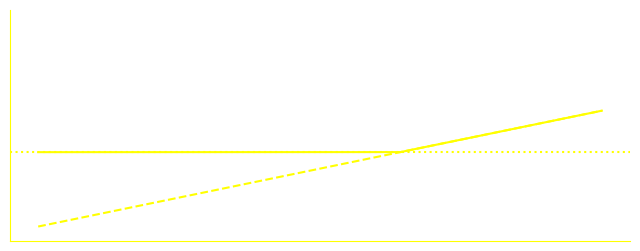

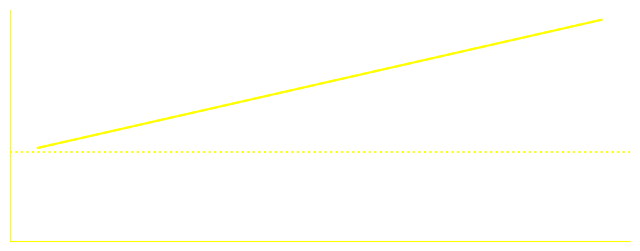

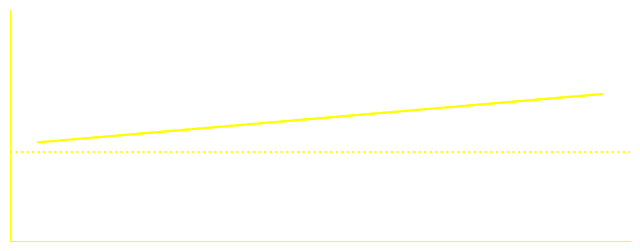

In [252]:

def plot_hidden(path=None):
    fig, ax = plt.subplots(n_hidden, figsize=(8, 3*n_hidden), sharex=True)
    for plot in range(n_hidden):
        set_spines(ax[plot])
    for i in range(n_hidden):
        ax[i].axhline(0, ls=":")
        ax[i].plot(x, hidden_components[:, i], ls='--', color=COLOR, label=f'Hidden node {i + 1}')
        ax[i].plot(x, torch.relu(hidden_components)[:, i], ls='-', color=COLOR, label='...after RELU')
        #print(ax[i].get_ylim())
        ax[i].set_ylim(-2.5, 4)
        ax[i].legend()
    if path:
        plt.savefig(f"../slides/neural_networks/assets/{path}.svg", format="svg", bbox_inches='tight', transparent=True)

def plot_single_hidden(i, path=None):
    fig, ax = plt.subplots(figsize=(8, 3))
    set_spines(ax)
    ax.axhline(0, ls=":", color=COLOR)
    ax.plot(x, hidden_components[:, i], ls='--', color=COLOR, label=f'Hidden node {i + 1}')
    ax.plot(x, torch.relu(hidden_components)[:, i], ls='-', color=COLOR, label='...after RELU')
    ax.set_ylim(-2.5, 4)
    #ax.legend()
    if path:
        plt.savefig(f"../slides/neural_networks/assets/{path}.svg", format="svg", bbox_inches='tight', transparent=True)

def plot_output(path=None, linear_regression=True, neural_network=True):
    arrowprops=dict(arrowstyle='->', color=COLOR, linewidth=1)
    fig, ax = plt.subplots(figsize=(8,8))
    set_spines(ax)
    ax.scatter(x[::9], y[::9], alpha=.6, facecolor='none', label='data', s=70, color=COLOR)
    # neural network
    if neural_network:
        ax.plot(x, y_pred, ls='-', color=COLOR)
        ax.annotate(
                'Neural Network',        
                xy=(1.57, .97),            # Arrowhead position
                xytext=(1.2, .85),        # Text position
                arrowprops=arrowprops,
                fontsize=12,                  
                color=COLOR,                
                ha='left',                  
                va='baseline')
    # linear regression
    if linear_regression:
        ax.plot(x, y_pred_linear_regression_intuition, ls='--', color=COLOR)
        ax.annotate(
                'Linear regression',        
                xy=(1.6, 0.63),            # Arrowhead position
                xytext=(1.2, .5),        # Text position
                arrowprops=arrowprops,
                fontsize=12,                  
                color=COLOR,                
                ha='left',                  
                va='baseline')
    
    ax.set_xlabel('x', color=COLOR, fontsize=12)
    ax.set_ylabel('y', color=COLOR, fontsize=12)
    if path:
        plt.savefig(f"../slides/neural_networks/assets/{path}.svg", format="svg", bbox_inches='tight', transparent=True)
        


#plot_hidden()
#plot_output(path="intuition_data", neural_network=False)
#plot_output(path="intuition_output_node")
plot_single_hidden(0, "intuition_hidden_node_1")
plot_single_hidden(1, "intuition_hidden_node_2")
plot_single_hidden(2, "intuition_hidden_node_3")
plot_single_hidden(3, "intuition_hidden_node_4")


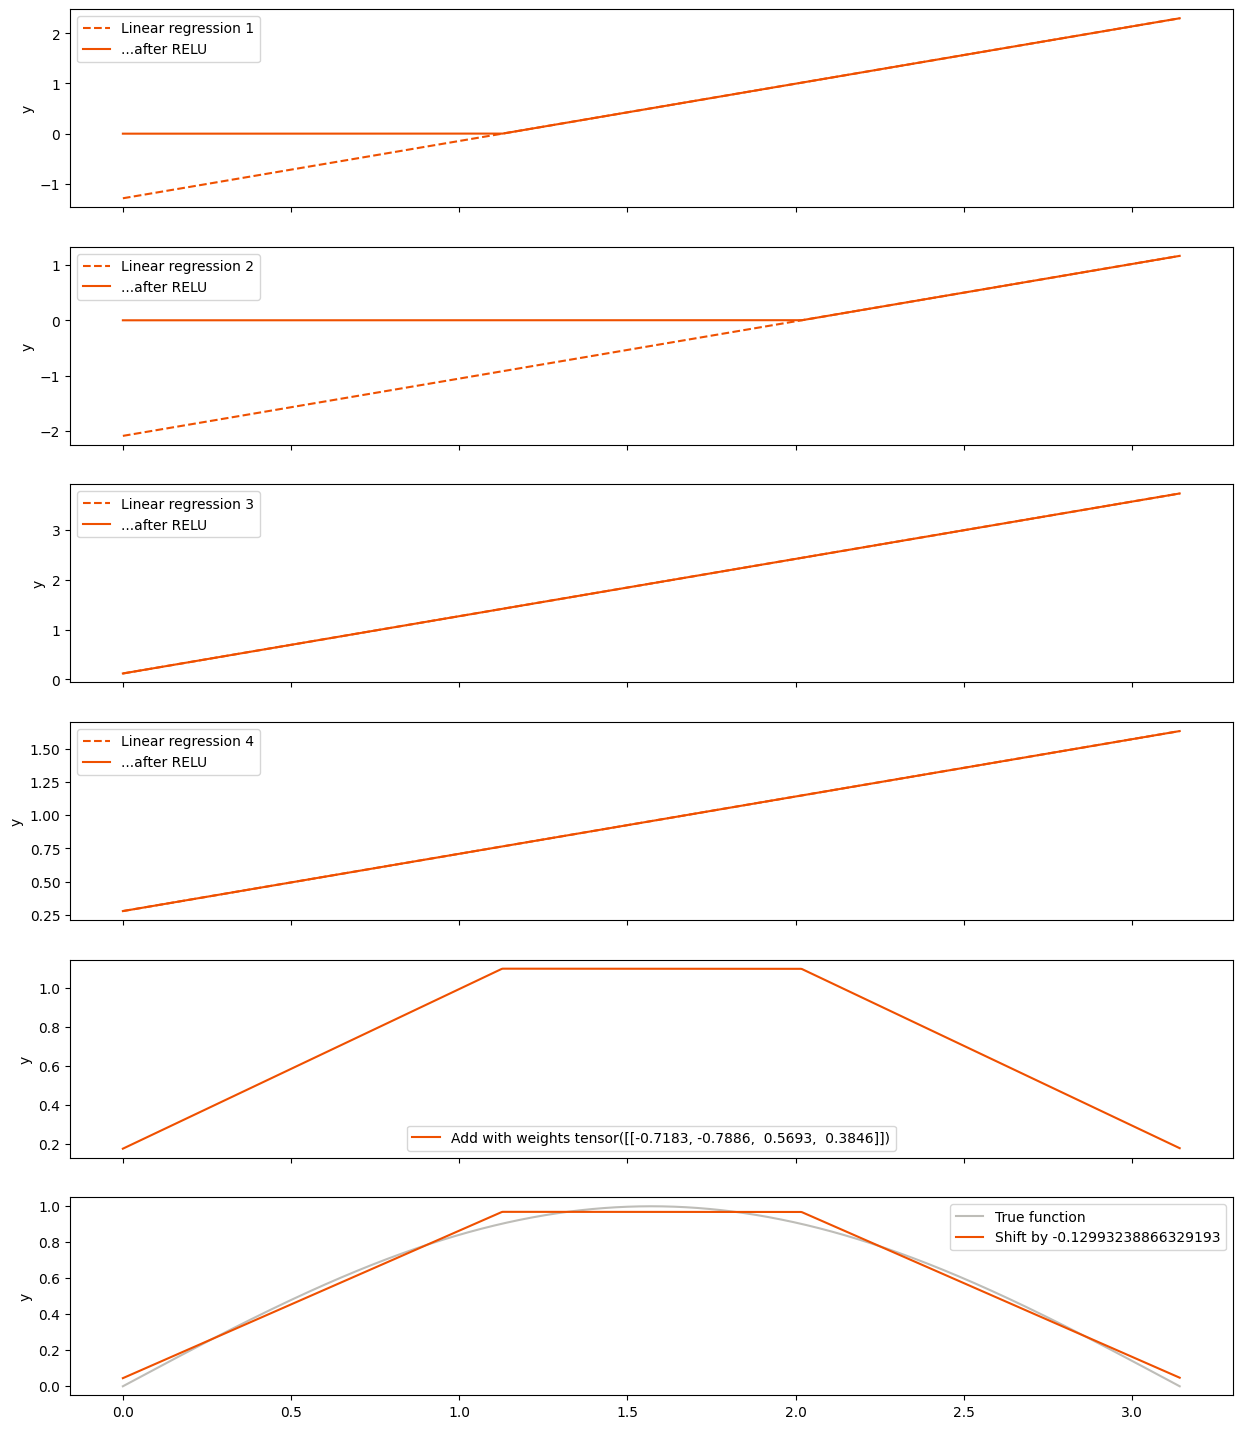

# Universal approximation theorem

In [50]:
# Create data
x_train = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1)
y_train = np.sin(x_train)

# Convert data to torch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define a feedforward neural network
class UniversalApproximator(nn.Module):
    def __init__(self):
        super(UniversalApproximator, self).__init__()
        self.hidden = nn.Linear(1, 20)  # Hidden layer with 20 neurons
        self.output = nn.Linear(20, 1)  # Output layer

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))  # Sigmoid activation function - makes illustration pretty fast
        x = self.output(x)  # No activation in the output layer
        return x

# Initialize the model, loss function, and optimizer
model = UniversalApproximator()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Make predictions after training
model.eval()
with torch.no_grad():
    predicted = model(x_train_tensor).numpy()

Epoch [100/5000], Loss: 0.13464656
Epoch [200/5000], Loss: 0.06610858
Epoch [300/5000], Loss: 0.04184468
Epoch [400/5000], Loss: 0.03266407
Epoch [500/5000], Loss: 0.01981777
Epoch [600/5000], Loss: 0.00731545
Epoch [700/5000], Loss: 0.00253256
Epoch [800/5000], Loss: 0.00106102
Epoch [900/5000], Loss: 0.00051612
Epoch [1000/5000], Loss: 0.00027336
Epoch [1100/5000], Loss: 0.00016288
Epoch [1200/5000], Loss: 0.00009133
Epoch [1300/5000], Loss: 0.00005899
Epoch [1400/5000], Loss: 0.00004179
Epoch [1500/5000], Loss: 0.00003091
Epoch [1600/5000], Loss: 0.00003949
Epoch [1700/5000], Loss: 0.00001901
Epoch [1800/5000], Loss: 0.00001540
Epoch [1900/5000], Loss: 0.00001273
Epoch [2000/5000], Loss: 0.00001065
Epoch [2100/5000], Loss: 0.00000997
Epoch [2200/5000], Loss: 0.00000770
Epoch [2300/5000], Loss: 0.00000661
Epoch [2400/5000], Loss: 0.00000630
Epoch [2500/5000], Loss: 0.00000498
Epoch [2600/5000], Loss: 0.00008680
Epoch [2700/5000], Loss: 0.00000382
Epoch [2800/5000], Loss: 0.00000335
E

In [167]:
# Linear fit for comparison
regr = LinearRegression()
regr.fit(x_train, y_train)
y_pred_linear_regression = regr.predict(x_train)

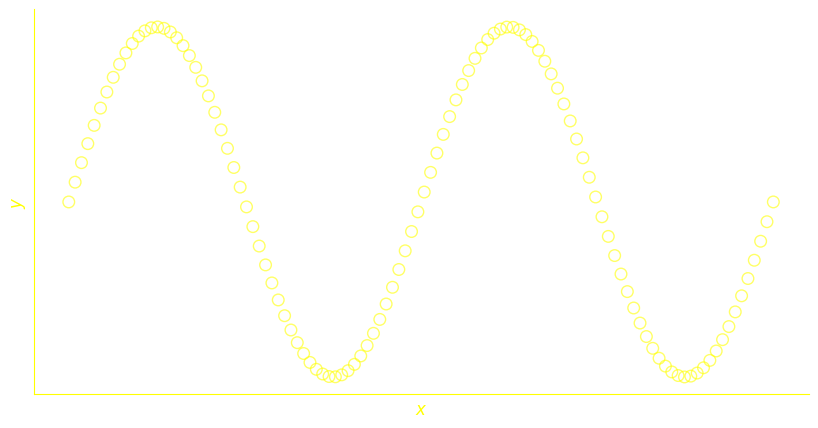

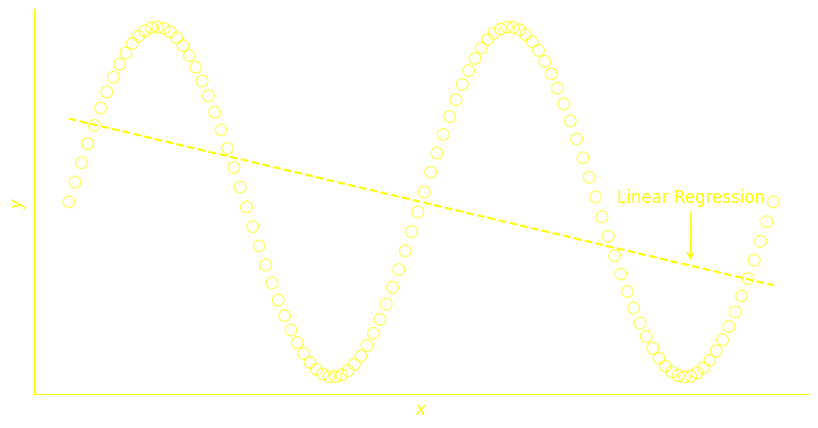

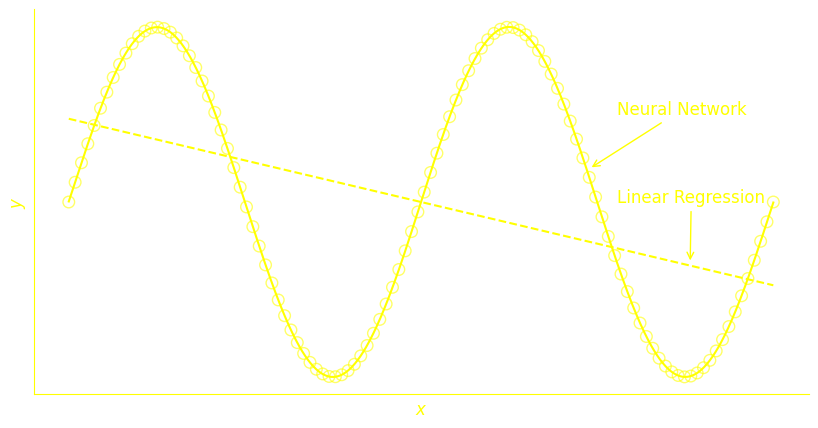

In [202]:
# Plot original sine function and the model's approximation
COLOR='yellow'
def plot_universal_approximation(path=None, linear_regression=True, neural_network=True):
    arrowprops=dict(arrowstyle='->', color=COLOR, linewidth=1)
    fig, ax = plt.subplots(figsize=(10, 5))
    set_spines(ax)
    ax.scatter(x_train[::9], y_train[::9], alpha=.6, facecolor='none', label='data', s=70, color=COLOR)
    if linear_regression:
        ax.plot(x_train, y_pred_linear_regression, label='Neural network approximation', color=COLOR, linestyle='--')
        ax.annotate(
            'Linear Regression',            
            xy=(4.8,-0.35),           # Arrowhead position
            xytext=(3.5,0),           # Text position
            arrowprops=arrowprops,
            fontsize=12,                
            color=COLOR,                
            ha='left',                  
            va='baseline')
    if neural_network:
        ax.plot(x_train, predicted, label='Neural network approximation', color=COLOR, linestyle='-')
        ax.annotate(
            'Neural Network',        
            xy=(3, 0.19),            # Arrowhead position
            xytext=(3.5, .5),        # Text position
            arrowprops=arrowprops,
            fontsize=12,                  
            color=COLOR,                
            ha='left',                  
            va='baseline')
    ax.set_xlabel('$x$', color=COLOR, fontsize=12)
    ax.set_ylabel('$y$', color=COLOR, fontsize=12)
    if path:
        plt.savefig(f"../slides/neural_networks/assets/{path}.svg", format="svg", bbox_inches='tight', transparent=True)
    plt.show()

plot_universal_approximation(path="universal_approximation_0", linear_regression=False, neural_network=False)
plot_universal_approximation(path="universal_approximation_1", linear_regression=True, neural_network=False)
plot_universal_approximation(path="universal_approximation_2", linear_regression=True, neural_network=True)
